# Este es un experimento para generar datos sintéticos.

In [ ]:
!pip install scikit-learn
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension
!pip install seaborn
!pip install binclass-tools
!pip install catboost
!pip install ctgan

In [2]:
# Importar librerías básicas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import bctools as bc
from sklearn import preprocessing
from sklearn import model_selection
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import neighbors
from catboost import CatBoostClassifier, Pool, metrics, cv
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import matthews_corrcoef, confusion_matrix

In [3]:
# Especificar columnas
relevant_columns = ['SKU','Tienda','FORMATO','Categoria','CLASE','SCLASE','DiaSem','Sem','Existencia','fiDesplazamiento','VentaPromedio','Y_Faltante']
num_columns = ['Existencia','fiDesplazamiento','VentaPromedio']
cat_columns = ['SKU','Tienda','FORMATO','Categoria','CLASE','SCLASE','DiaSem','Sem']
target = ['Y_Faltante']

In [4]:
dtype = {'SKU':'object','FORMATO':'object','REGION':'object','Tienda':'object','Categoria':'object','Proveedor':'object','CLASE':'object','SCLASE':'object','Mes':'object','DiaSem':'object','Sem':'object','Existencia':'float','fiDesplazamiento':'float',
\
'VentaPromedio':'float','Y_Faltante':'int'}

In [5]:
# Abrir el archivo
file = '8semana.csv'
data = pd.read_csv(file, header=0,low_memory=False, usecols=relevant_columns,dtype=dtype)
print('rows:', data.shape[0], ' columns:', data.shape[1])

rows: 3304660  columns: 12


In [6]:
data = data[0:8114]

In [7]:
data = data.dropna()

In [8]:
#from ctgan import CTGANSynthesizer

# Identifies all the discrete columns

# Initiates the CTGANSynthesizer and call its fit method to pass in the table
# Another hyper-parameter that can be tunned is 
#ctgan = CTGANSynthesizer(epochs=200,verbose=True,cuda=True)
#ctgan.fit(data, cat_columns)

#generate synthetic data, 10000 rows of data

#synthetic_data = ctgan.sample(10000)
#print(synthetic_data.head(5))


#data = pd.concat([data,synthetic_data],join='inner')
#print('rows:', data.shape[0], ' columns:', data.shape[1])

yes %: 38.674470104397344- no %: 61.325529895602656


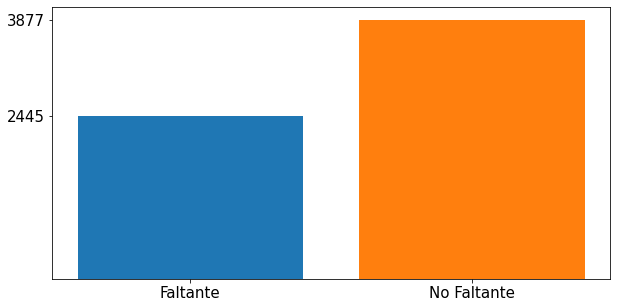

In [9]:
target = data['Y_Faltante']
yes = target[target == 1].count()
no = target[target == 0].count()
print('yes %: ' + str(yes/len(target)*100) + '- no %: ' \
        + str(no/len(target)*100))

fig, ax = plt.subplots(figsize=(10,5))
plt.bar("Faltante", yes)
plt.bar("No Faltante", no)
ax.set_yticks([yes,no])
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

yes %: 50.0- no %: 50.0


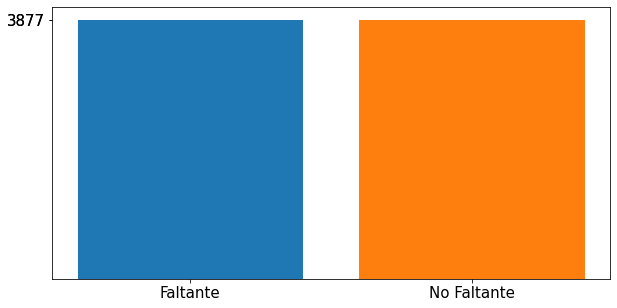

In [10]:
#Balanceamos a 50% - 50% nuestro conjunto de datos.
data_yes = data[data["Y_Faltante"] == 1]
data_no = data[data["Y_Faltante"] == 0]
over_sampling = data_yes.sample(no, replace=True, \
random_state = 0)
balanced_data = pd.concat([data_no, over_sampling], \
axis=0)
data = balanced_data.reset_index(drop=True)


# Revisamos (de nuevo) la proporción de datos
target = data['Y_Faltante']
yes = target[target == 1].count()
no = target[target == 0].count()
print('yes %: ' + str(yes/len(target)*100) + '- no %: ' \
        + str(no/len(target)*100))

fig, ax = plt.subplots(figsize=(10,5))
plt.bar("Faltante", yes)
plt.bar("No Faltante", no)
ax.set_yticks([yes,no])
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

In [11]:
X = data.drop('Y_Faltante',axis=1)
y = data.Y_Faltante


# Se construyen los conjuntos de entrenamiento y prueba sobre los que se aplicarán algoritmos de machine learning
X_train, X_val, y_train, y_val = train_test_split(X,y, test_size=0.2, random_state=0)
print('Entrenamiento:', X_train.shape[0], ' Prueba:', X_val.shape[0])

Entrenamiento: 6203  Prueba: 1551


In [12]:
# Aislamos las variables numéricas y realizamos un min-max scaling sobre ellas
categorical = X_train.drop(columns=['Existencia','fiDesplazamiento','VentaPromedio'])
numerical = X_train[['Existencia','fiDesplazamiento','VentaPromedio']]
numerical_scaled = (numerical - numerical.min())/(numerical.max() - numerical.min())
X_train = pd.concat([categorical,numerical_scaled], axis=1)


indices_categoricos = np.where(X_train.dtypes != float)[0]

num_ind = np.where(X_train.dtypes != object)[0]

In [13]:
params = {
    'l2_leaf_reg':int(2.0),
    'iterations':100,
    #'custom_loss':[metrics.Accuracy()],
    'loss_function':metrics.Logloss(),
    #'eval_metric':LoglossMetric(),
    'random_seed': 0,
    'task_type':'GPU',
    'logging_level': 'Verbose',
    'use_best_model': True,
}

In [14]:
model = CatBoostClassifier(**params)
model.fit(X_train,y_train,cat_features=indices_categoricos, eval_set=(X_val,y_val),logging_level='Verbose',save_snapshot=True,plot=True)

print('Simple model tree count: {}'.format(model.tree_count_))
print('Simple model validation accuracy: {:.4}'.format(
    accuracy_score(y_val, model.predict(X_val))
))
print('')

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6770523	test: 0.6780571	best: 0.6780571 (0)	total: 7.54ms	remaining: 747ms
1:	learn: 0.6609316	test: 0.6623929	best: 0.6623929 (1)	total: 14.6ms	remaining: 716ms
2:	learn: 0.6455246	test: 0.6475304	best: 0.6475304 (2)	total: 19.3ms	remaining: 624ms
3:	learn: 0.6311160	test: 0.6335119	best: 0.6335119 (3)	total: 24.1ms	remaining: 578ms
4:	learn: 0.6171974	test: 0.6195076	best: 0.6195076 (4)	total: 27.2ms	remaining: 516ms
5:	learn: 0.6046173	test: 0.6074799	best: 0.6074799 (5)	total: 32.2ms	remaining: 504ms
6:	learn: 0.5920824	test: 0.5954942	best: 0.5954942 (6)	total: 37.5ms	remaining: 498ms
7:	learn: 0.5813787	test: 0.5842008	best: 0.5842008 (7)	total: 41.4ms	remaining: 476ms
8:	learn: 0.5697596	test: 0.5729863	best: 0.5729863 (8)	total: 46.4ms	remaining: 469ms
9:	learn: 0.5591060	test: 0.5627933	best: 0.5627933 (9)	total: 50.1ms	remaining: 451ms
10:	learn: 0.5422751	test: 0.5499833	best: 0.5499833 (10)	total: 53.8ms	remaining: 435ms
11:	learn: 0.5261862	test: 0.5352473	best

In [15]:
y_pred = model.predict(X_val)
accuracy = accuracy_score(y_val,y_pred)
recall = recall_score(y_val,y_pred,average='binary',pos_label=1)
precision = precision_score(y_val,y_pred,average='binary',pos_label=0)
balanced_accuracy = balanced_accuracy_score(y_val,y_pred)
f1 = f1_score(y_val,y_pred,pos_label=1)
print(f'Accuracy: {accuracy}')
print(f'True Positive Rate {recall}')
print(f'Precision {precision}')
print(f'Balanced accuracy {balanced_accuracy}')
print(f'f1 score {f1}')

Accuracy: 0.9374597034171502
True Positive Rate 0.9074550128534704
Precision 0.9121951219512195
Balanced accuracy 0.9375567431667093
f1 score 0.935719019218025


In [16]:
# Calculamos las entradas de la matriz de confusión
tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()
tn,fp,fn,tp

(748, 25, 72, 706)

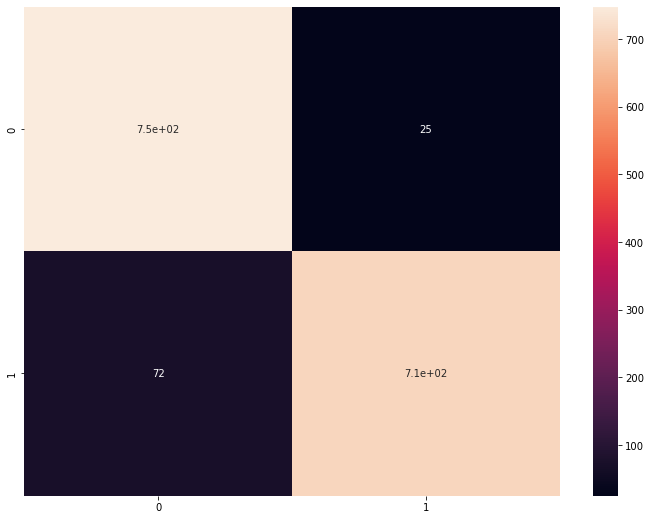

In [17]:
y_pred = model.predict(X_val)
# Dibujamos también la matriz de confusión para nuestro modelo
mat = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(12, 9))
sns.heatmap(mat, annot=True)
plt.show()

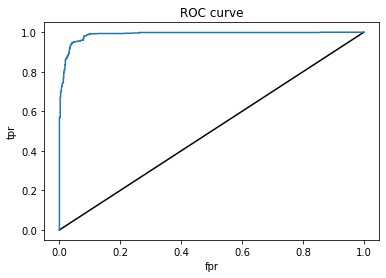

In [18]:
# Dibujamos la curva de ROC para este modelo
from sklearn.metrics import roc_curve
y_pred_proba = model.predict_proba(X_val)[:,1]
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba,pos_label=1)
plt.plot([0,1],[0,1],'k-')
plt.plot(fpr,tpr, label='Knn')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('ROC curve')
plt.show()

## Buscamos incorporar un algoritmo corrector

In [19]:
nuevos_datos = data.copy()
nuevos_datos['Predicción_Ago'] = model.predict(nuevos_datos.drop('Y_Faltante',axis=1))

In [20]:
nuevos_datos[['0','1']] = model.predict_proba(nuevos_datos.drop(['Y_Faltante','Predicción_Ago'],axis=1))

In [21]:
# 0 va a indicar acuerdo y 1 indica desacuerdo
faltante_real = nuevos_datos['Y_Faltante']
faltante_predicho = nuevos_datos['Predicción_Ago']
verdaderos_positivos = (faltante_real + faltante_predicho) % 2
nuevos_datos['Acuerdo'] = verdaderos_positivos 

In [22]:
# Aquí reportamos el numero de acuerdos y desacuerdos
verdaderos_positivos.value_counts()

0    7458
1     296
dtype: int64

yes %: 3.8173845757028633- no %: 96.18261542429714


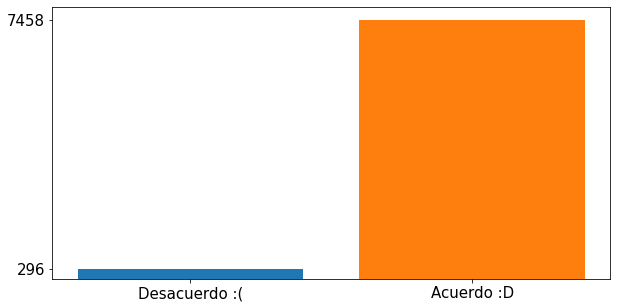

In [23]:
# Revisamos (de nuevo) la proporción de datos
target = verdaderos_positivos
yes = target[target == 1].count()
no = target[target == 0].count()
print('yes %: ' + str(yes/len(target)*100) + '- no %: ' \
        + str(no/len(target)*100))


fig, ax = plt.subplots(figsize=(10,5))
plt.bar("Desacuerdo :(", yes)
plt.bar("Acuerdo :D", no)
ax.set_yticks([yes,no])
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

In [24]:
buenas = nuevos_datos[nuevos_datos['Acuerdo']==0]
malas = nuevos_datos[nuevos_datos['Acuerdo']==1]

In [25]:
num = len(buenas)-len(malas)

In [26]:
from ctgan import CTGANSynthesizer

# Identifies all the discrete columns

# Initiates the CTGANSynthesizer and call its fit method to pass in the table
# Another hyper-parameter that can be tunned is 
ctgan = CTGANSynthesizer(epochs=100,verbose=True,cuda=True)
ctgan.fit(malas, cat_columns)

#generate synthetic data, 10000 rows of data

synthetic_data = ctgan.sample(num)
print(synthetic_data.head(5))

malas_oversampleadas = pd.concat([malas,synthetic_data])

data = pd.concat([buenas,malas_oversampleadas],join='inner')
print('rows:', data.shape[0], ' columns:', data.shape[1])

/home/ramiro/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:143: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  cluster.KMeans(
/home/ramiro/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:143: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  cluster.KMeans(
/home/ramiro/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:277: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
/home/ramiro/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:143: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  cluster.KMeans(
/home/ramiro/anaconda3/lib/python3.9/site-packages/rdt/transformers/base.py:156: P

Epoch 1, Loss G:  2.7067,Loss D:  0.0006
Epoch 2, Loss G:  2.6354,Loss D: -0.0044
Epoch 3, Loss G:  2.6250,Loss D: -0.0207
Epoch 4, Loss G:  2.7532,Loss D: -0.0256
Epoch 5, Loss G:  2.6235,Loss D: -0.0502
Epoch 6, Loss G:  2.7263,Loss D: -0.0655
Epoch 7, Loss G:  2.6785,Loss D: -0.0915
Epoch 8, Loss G:  2.7322,Loss D: -0.1472
Epoch 9, Loss G:  2.7909,Loss D: -0.1524
Epoch 10, Loss G:  2.4730,Loss D: -0.1817
Epoch 11, Loss G:  2.6701,Loss D: -0.1967
Epoch 12, Loss G:  2.6523,Loss D: -0.2014
Epoch 13, Loss G:  2.7049,Loss D: -0.2022
Epoch 14, Loss G:  2.6277,Loss D: -0.2179
Epoch 15, Loss G:  2.5315,Loss D: -0.2304
Epoch 16, Loss G:  2.7215,Loss D: -0.1893
Epoch 17, Loss G:  2.6965,Loss D: -0.1871
Epoch 18, Loss G:  2.6386,Loss D: -0.1673
Epoch 19, Loss G:  2.5943,Loss D: -0.1679
Epoch 20, Loss G:  2.6176,Loss D: -0.1523
Epoch 21, Loss G:  2.5435,Loss D: -0.1466
Epoch 22, Loss G:  2.6904,Loss D: -0.1785
Epoch 23, Loss G:  2.6535,Loss D: -0.1280
Epoch 24, Loss G:  2.5373,Loss D: -0.1415
E

In [27]:
X = data[['Predicción_Ago','0','1']]
y = data.Y_Faltante

In [28]:
# Se construyen los conjuntos de entrenamiento y prueba sobre los que se aplicarán algoritmos de machine learning
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=0)
print('Entrenamiento:', X_train.shape[0], ' Prueba:', X_val.shape[0])

Entrenamiento: 12678  Prueba: 2238


# Implementamos Random Forest como corrector

In [29]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(random_state=0)
rfc.fit(X_train, y_train)
rfc.predict(X_val)
acc_train = rfc.score(X_train,y_train)
acc_test = rfc.score(X_val,y_val)

print(f'Precisión entrenamiento: {acc_train.round(4)}, Presición validación: {acc_test.round(4)}')

Precisión entrenamiento: 0.9992, Presición validación: 0.8123


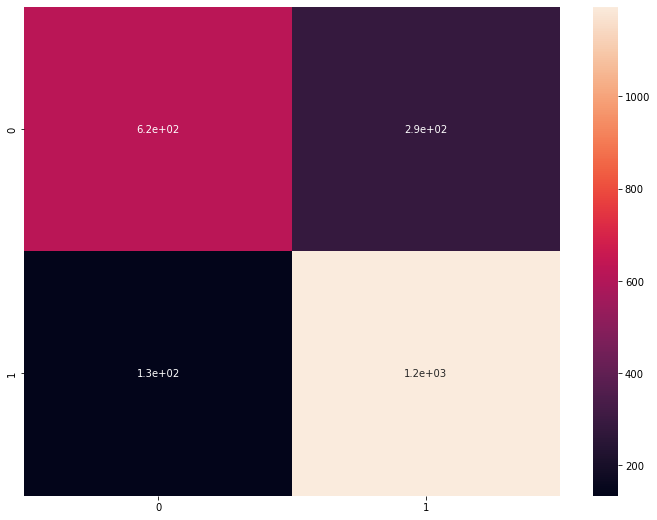

In [30]:
from sklearn.metrics import confusion_matrix
#y_test = label_test
y_pred = rfc.predict(X_val)
mat = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(12, 9))
sns.heatmap(mat, annot=True)
plt.show()

In [31]:
accuracy = accuracy_score(y_val,y_pred)
recall = recall_score(y_val,y_pred)
precision = precision_score(y_val,y_pred)
balanced_accuracy = balanced_accuracy_score(y_val,y_pred)
f1 = f1_score(y_val,y_pred)
print(f'Accuracy: {accuracy}')
print(f'True Positive Rate {recall}')
print(f'Precision {precision}')
print(f'Balanced accuracy {balanced_accuracy}')
print(f'f1 score {f1}')

Accuracy: 0.8123324396782842
True Positive Rate 0.8991723100075244
Precision 0.8068872383524646
Balanced accuracy 0.7922704234306048
f1 score 0.8505338078291815


In [32]:
# Calculamos las entradas de la matriz de confusión
tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()
tn,fp,fn,tp

(623, 286, 134, 1195)